In [2]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

pd.set_option('display.float_format', lambda x: '%.2f' % x)

csr_dataset = pd.read_csv('../../../data/core-web-vitals/lcp/details-csr-throttled.csv', sep=',')
ssrh_dataset = pd.read_csv('../../../data/core-web-vitals/lcp/details-ssrh-throttled.csv', sep=',')

features = ['start','end','duration','name','element','url','id','loadTime','renderTime']
target_features = ['start','end','loadTime','renderTime']

# Remove Java warmup
csr_dataset = csr_dataset.iloc[5:]
ssrh_dataset = ssrh_dataset.iloc[5:]

csr_dataset = csr_dataset[csr_dataset['type'] == 'LCP']
ssrh_dataset = ssrh_dataset[ssrh_dataset['type'] == 'LCP']

datasets =	{
  "csr": csr_dataset,
  "ssr h": ssrh_dataset,
}

csr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 6 to 1008
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   idx         502 non-null    int64  
 1   site        502 non-null    object 
 2   date        502 non-null    object 
 3   time        502 non-null    object 
 4   type        502 non-null    object 
 5   start       502 non-null    float64
 6   end         502 non-null    float64
 7   duration    502 non-null    float64
 8   name        502 non-null    object 
 9   element     502 non-null    object 
 10  url         502 non-null    object 
 11  id          0 non-null      float64
 12  loadTime    502 non-null    float64
 13  renderTime  502 non-null    float64
dtypes: float64(6), int64(1), object(7)
memory usage: 58.8+ KB


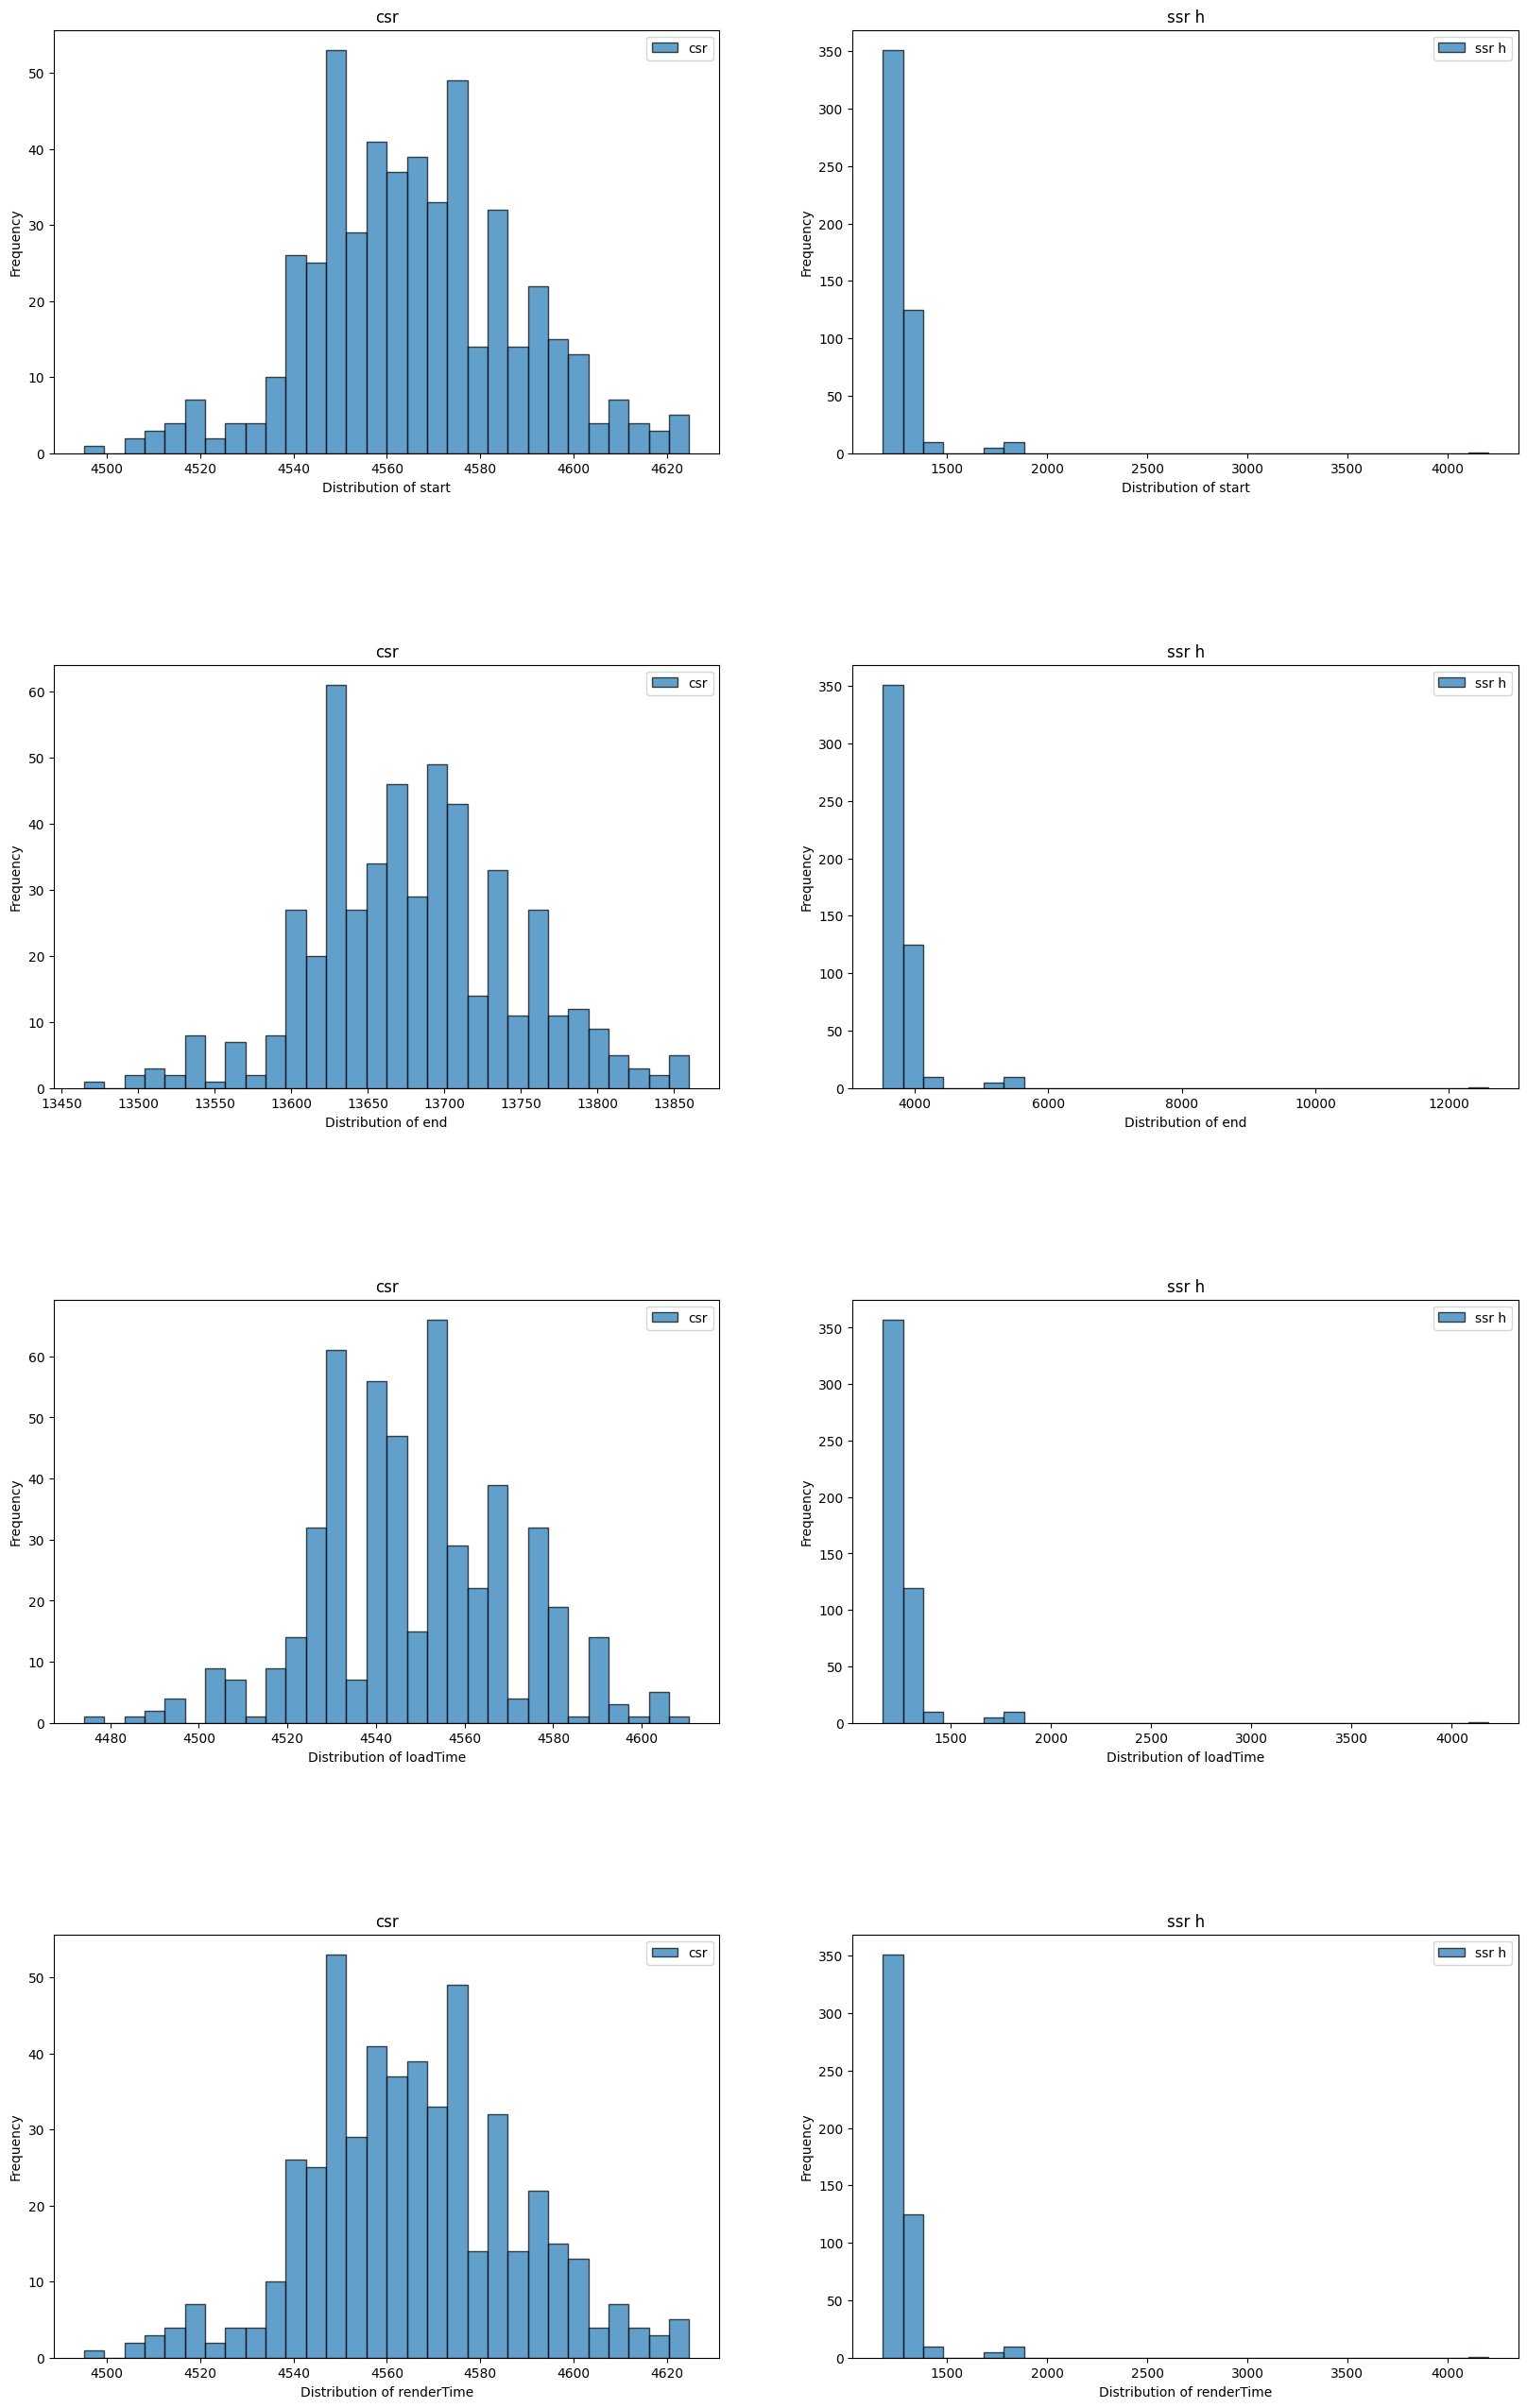

In [3]:

def plot_histogram(d, f, loc):
    loc.hist(datasets[d][f].dropna(), bins=30, alpha=0.7, label=d, edgecolor='k')
    loc.set_title(d)
    loc.set_ylabel('Frequency')
    loc.set_xlabel(f'Distribution of {f}')
    loc.legend()

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_histogram, target_features)
plt.show()

       Total Points  Outliers Percentage Removed
csr             502        51              10.2%
ssr h           502        51              10.2%


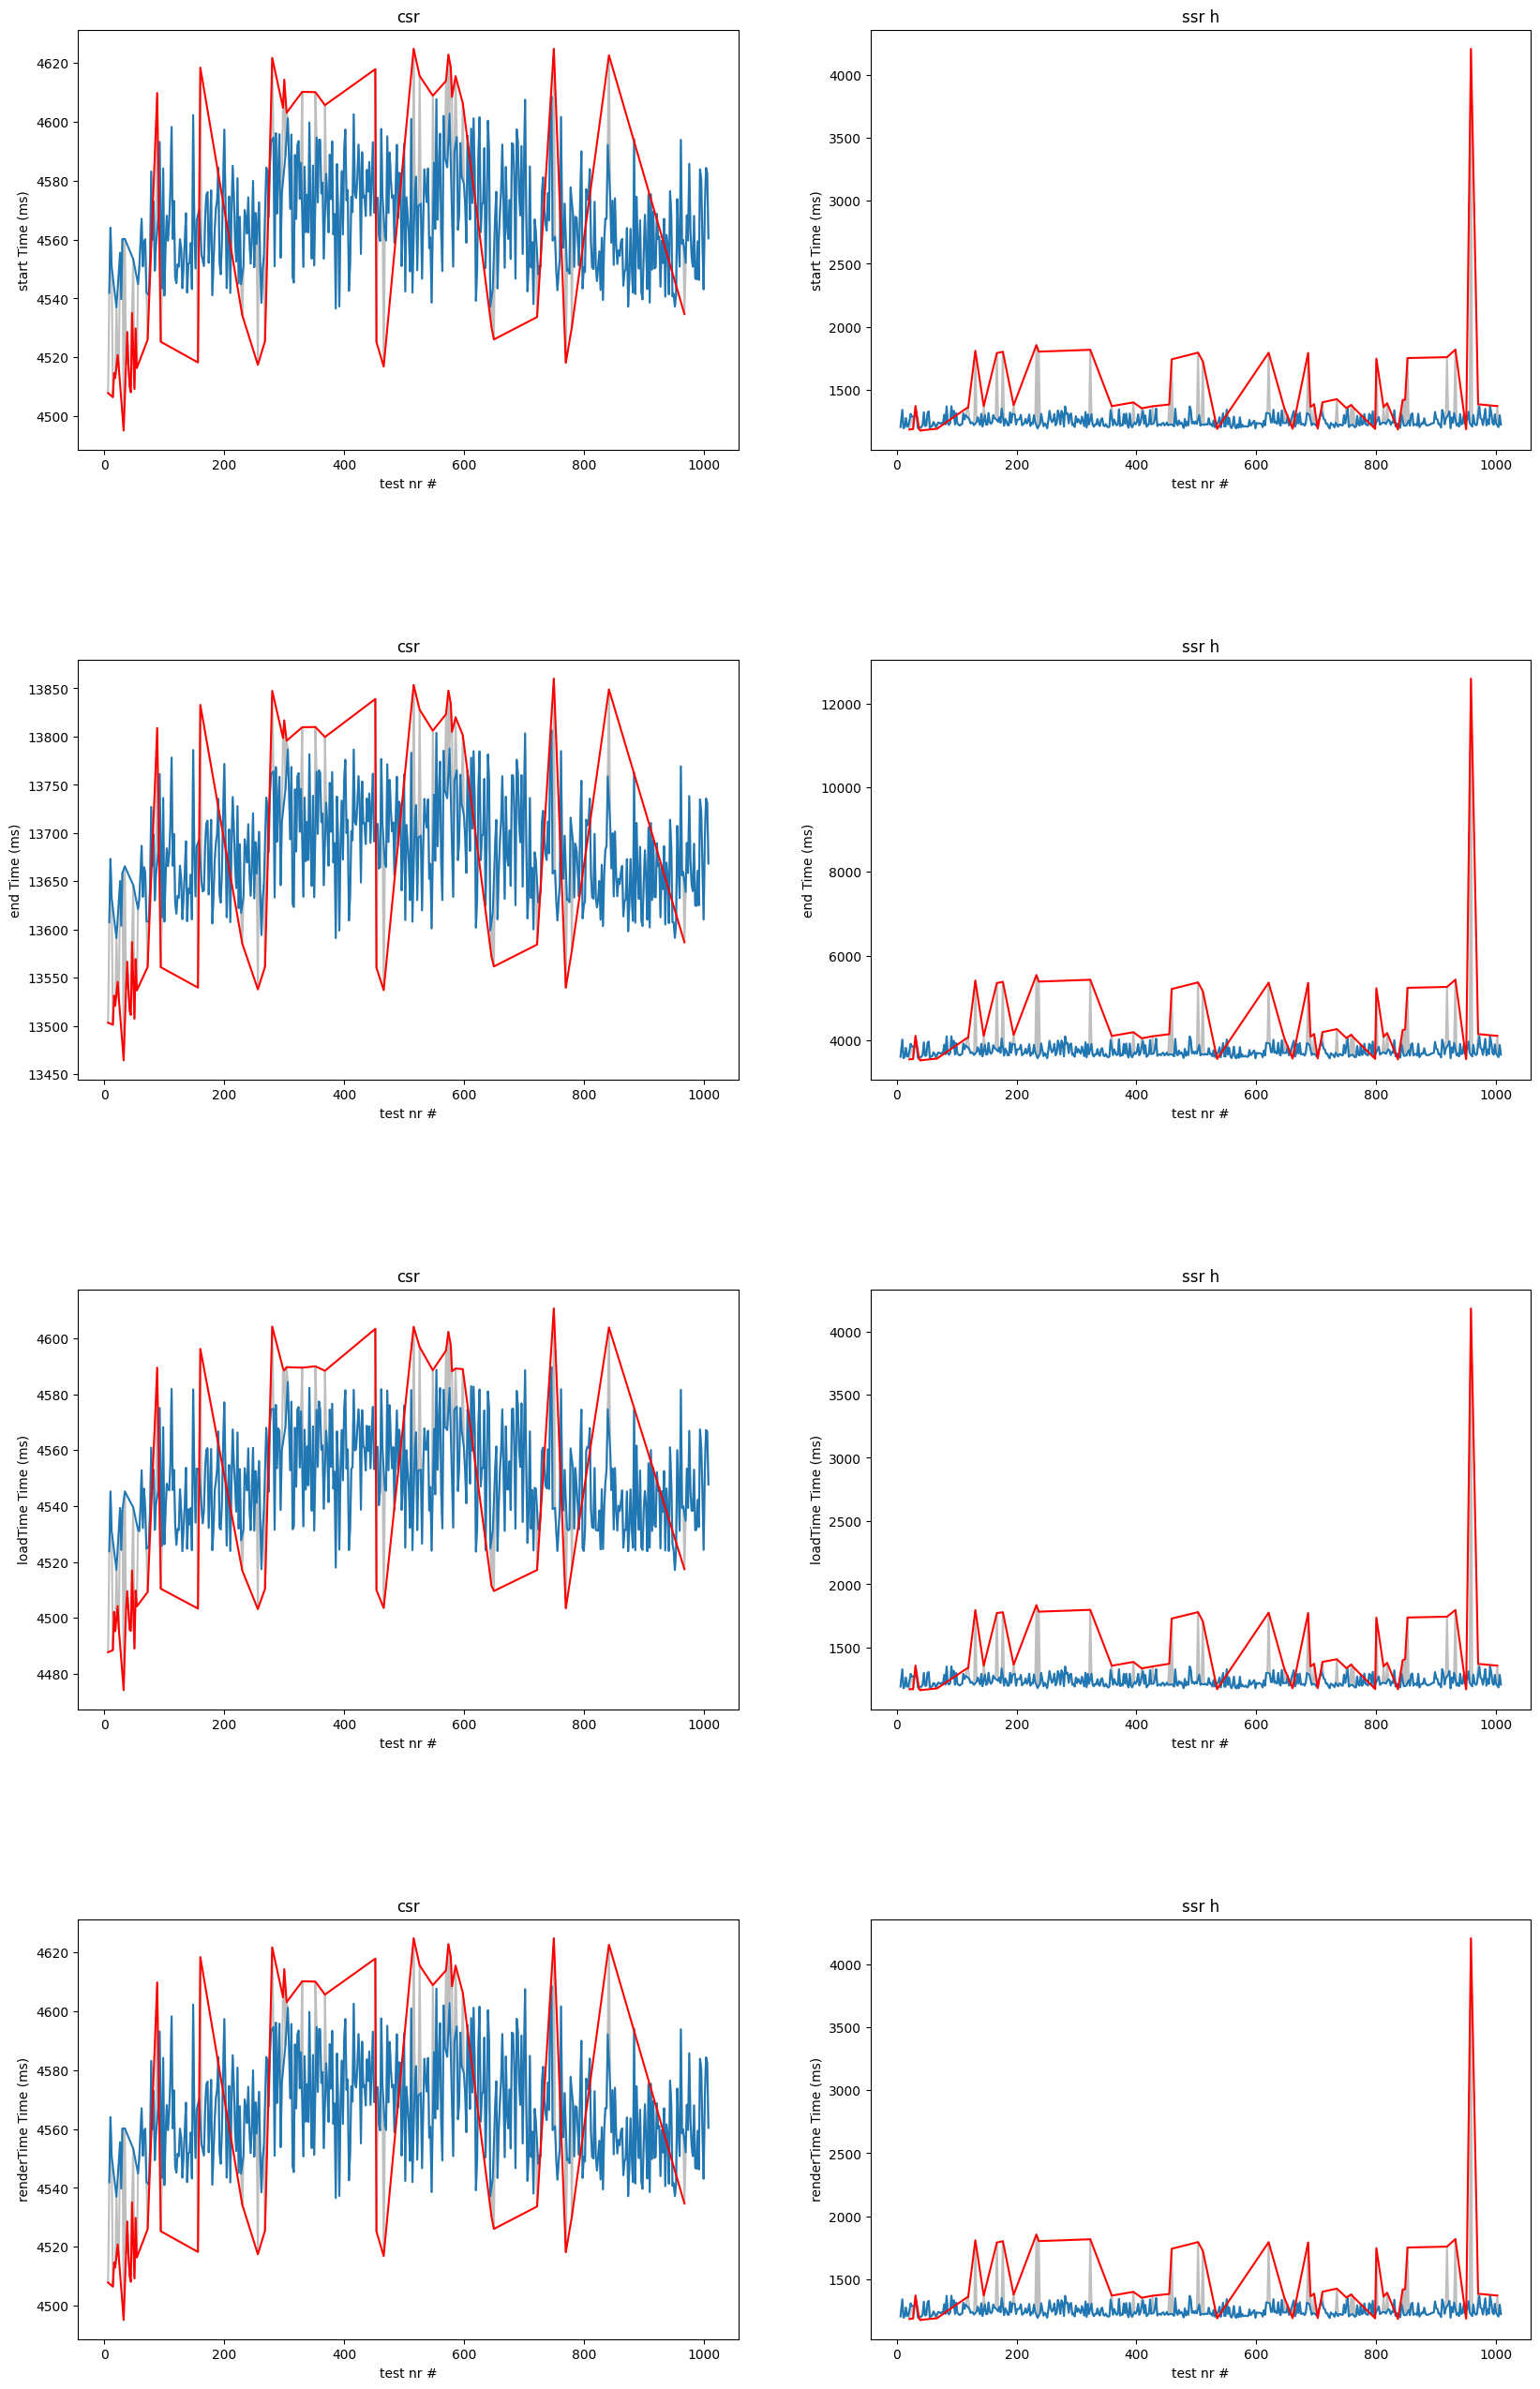

In [5]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

# def plot_outliers(d, f, loc, mask):
#     loc.hist(datasets[d][f][mask[d]], bins=30, alpha=0.7, label='Inliers', edgecolor='k')
#     loc.hist(datasets[d][f][~mask[d]], bins=30, alpha=0.7, label='Outliers', color='red', edgecolor='k')
#     loc.set_title(d)
#     loc.set_ylabel('Frequency')
#     loc.set_xlabel(f'Distribution of {f}')
#     loc.legend()


def plot_outliers(d, f, loc, mask):
    loc.plot(datasets[d][f], label='dirty', color='gray', alpha=0.5)
    loc.plot(datasets[d][f][mask[d]], label=d)
    loc.plot(datasets[d][f][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'{f} Time (ms)') 
    loc.set_xlabel('test nr #') 

def visualize_outliers(features, masks, height=8):
    rows = len(features)
    cols = len(datasets)
    
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_outliers(d, f, axes[y, x], masks)
    return plt

def print_outlier_stats(datasets, masks):
    stats = {}
    for name, df in datasets.items():
        total = len(df)
        outliers = (~masks[name]).sum()
        pct = (outliers / total) * 100
        stats[name] = {
            'total': total,
            'outliers': outliers,
            'percentage': pct
        }
    
    stats_df = pd.DataFrame({
        'Total Points': [stats[name]['total'] for name in stats],
        'Outliers': [stats[name]['outliers'] for name in stats],
        'Percentage Removed': [f"{stats[name]['percentage']:.1f}%" for name in stats]
    }, index=datasets.keys())
    
    return stats_df

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

print(print_outlier_stats(datasets, masks))

visualize_outliers(target_features, masks)
plt.show()

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

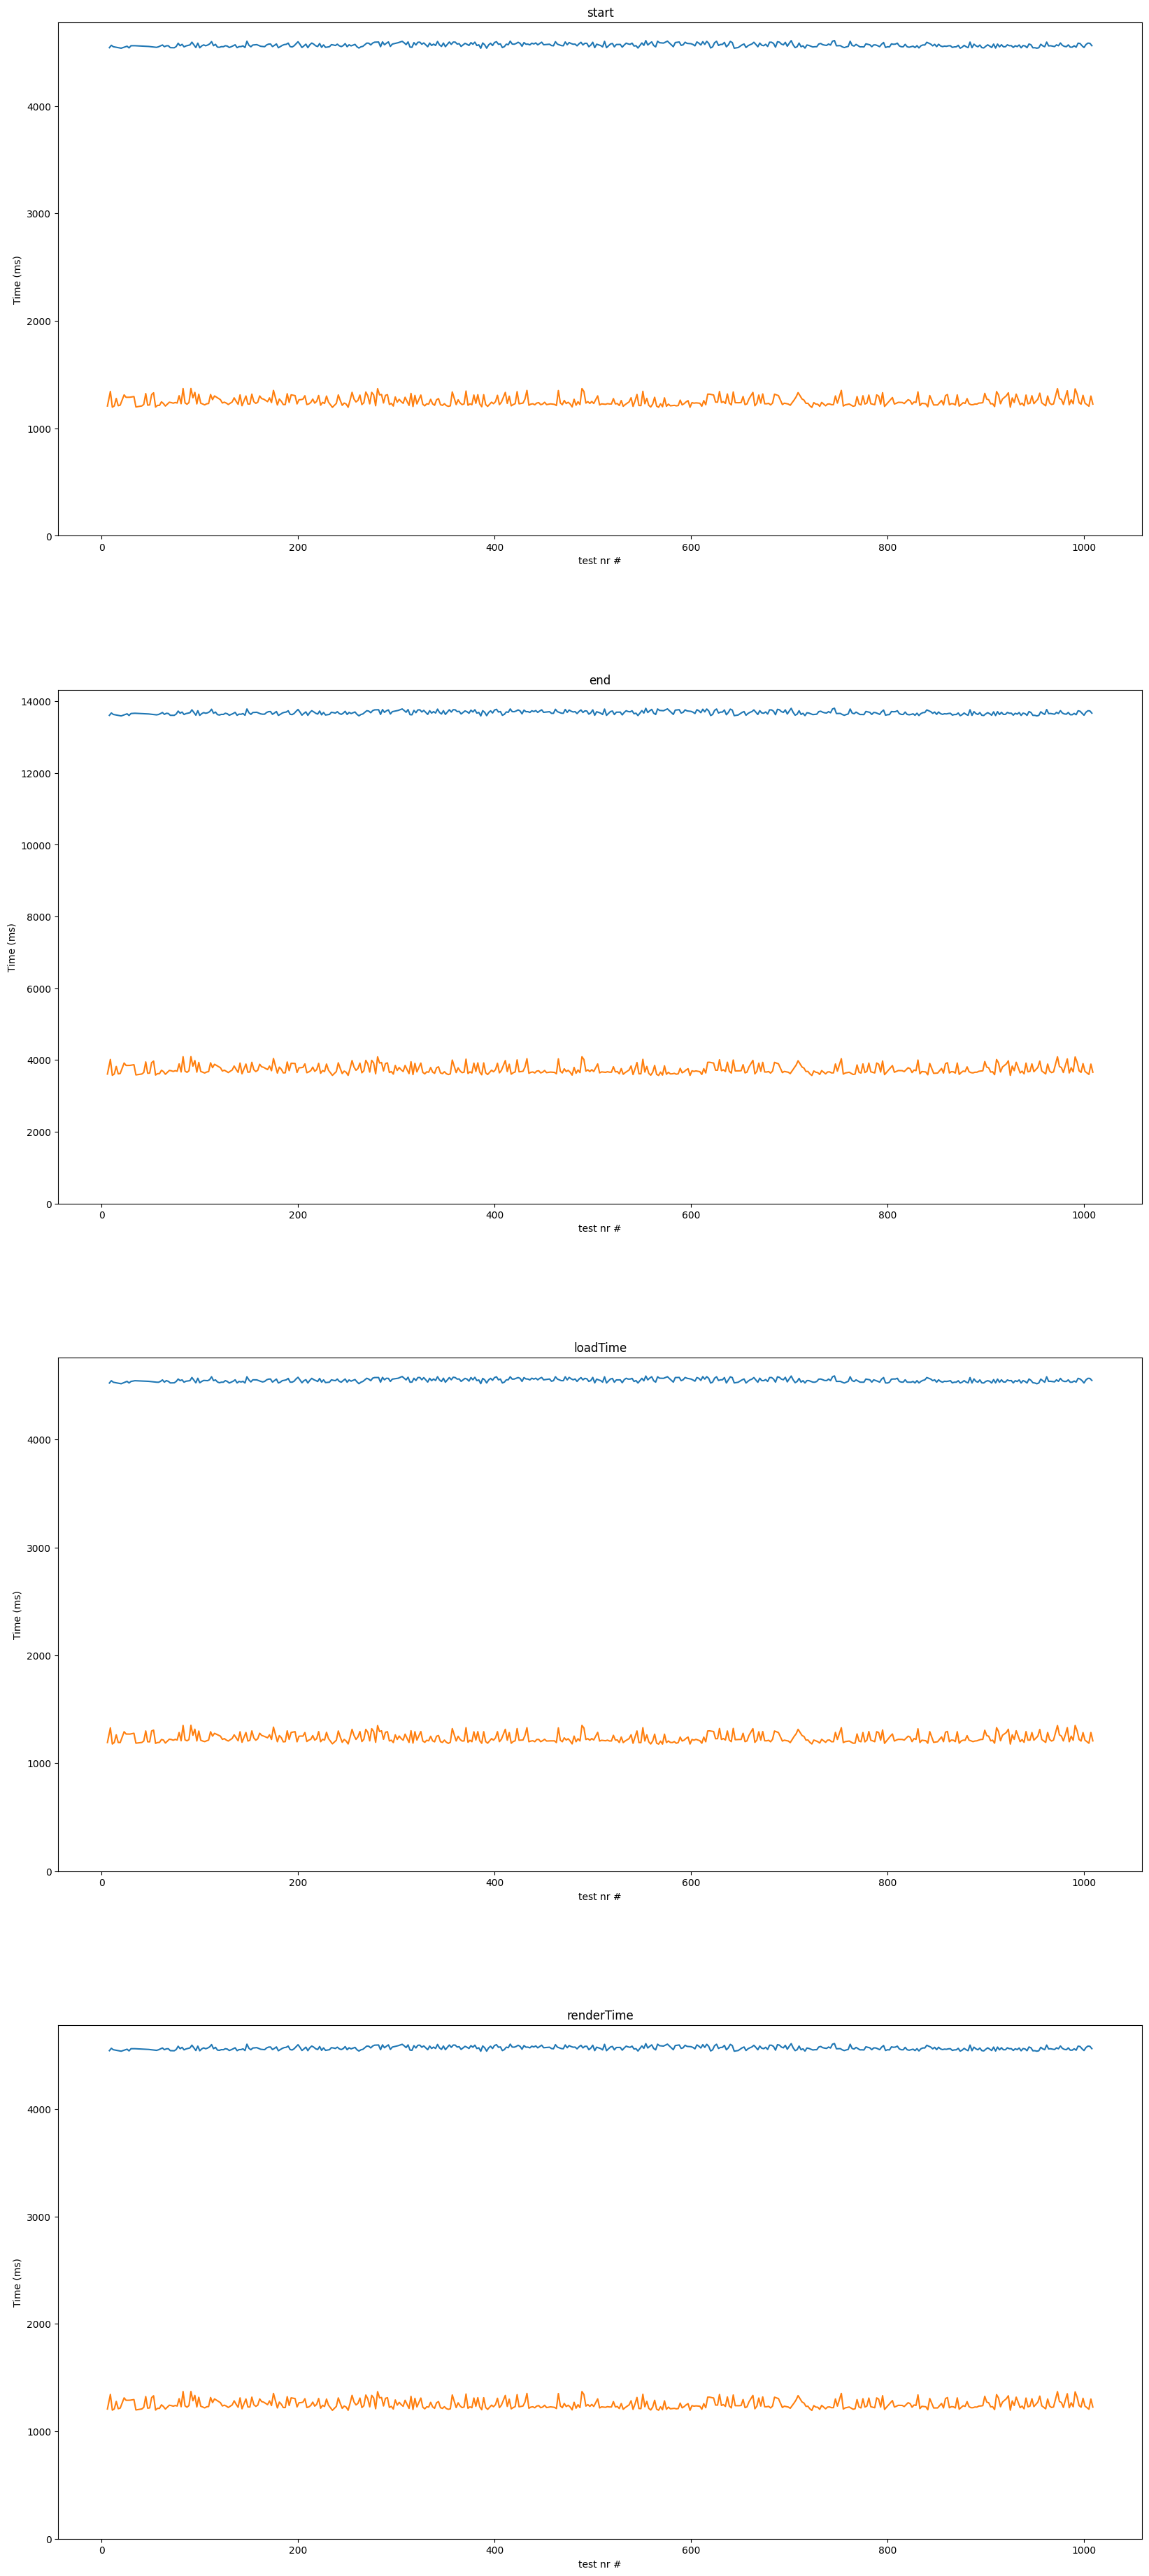

In [6]:
def ceildiv(a, b): return -(a // -b)

def plot_box_plot(f, loc):
    [loc.plot(cleaned_datasets[d][f], label=d) for d in cleaned_datasets]

    loc.set_title(f)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.set_ylim(bottom=0)


def graphs(plot_func, features, height=10):
    rows = len(features)

    _, axes = plt.subplots(nrows=rows, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

graphs(plot_box_plot, target_features)

In [7]:
metrics = {
    'ttfb': 'less',
    'fcp': 'less', 
    'lcp': 'greater',
    'tbt': 'greater',
    'navTime': 'greater'
}

results = pd.DataFrame([
    [metric, alt, stats.mannwhitneyu(cleaned_datasets["csr"][metric], 
                                   cleaned_datasets["ssr h"][metric], 
                                   alternative=alt)[1]]
    for metric, alt in metrics.items()
], columns=['metric', 'hypothesis', 'p_value'])

results['adjusted_p'] = multipletests(results['p_value'], method='bonferroni')[1]
results['significant'] = results['adjusted_p'] < 0.05

print(results)

KeyError: 'ttfb'

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

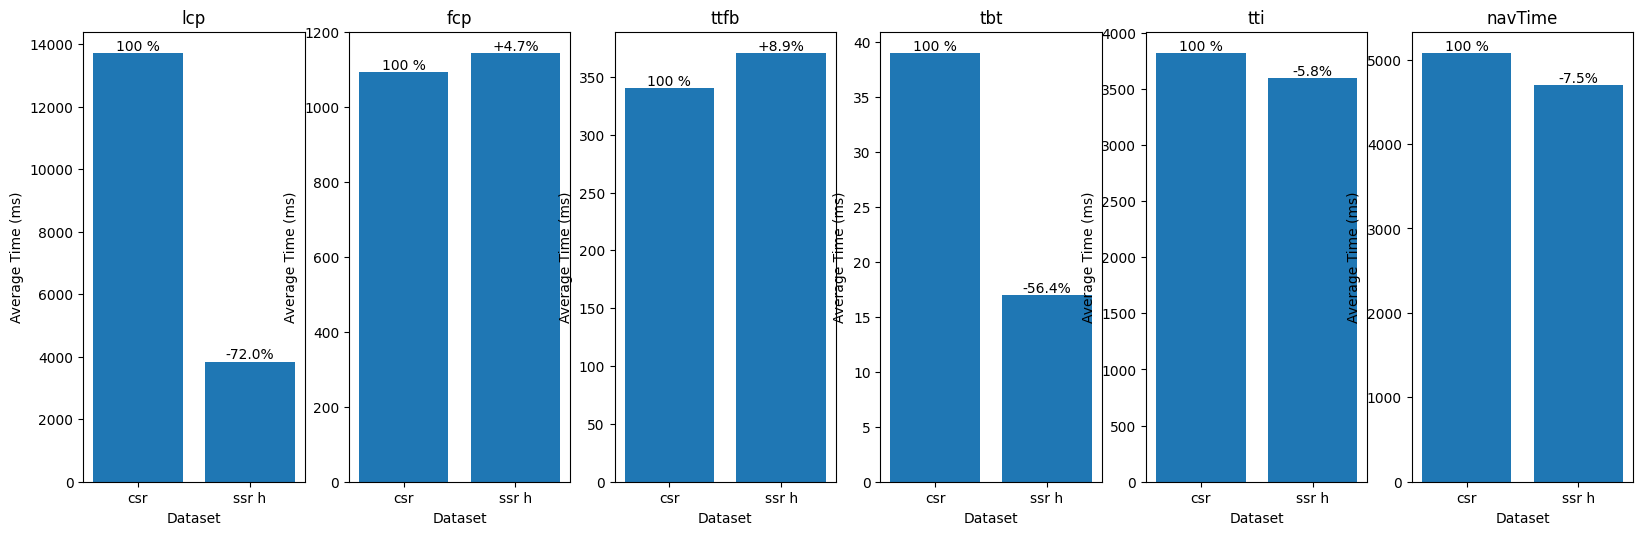

In [ ]:
def plot_bar_chart(feature, loc):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'100 %' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    loc.set_ylabel('Average Time (ms)')
    loc.set_xlabel('Dataset')

def graphs(plot_func, features, height=10):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, 5))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

graphs(plot_bar_chart, target_features)

# EXPLANATION
- **startTime:** Returns the value of this entry's renderTime if it is not 0, otherwise the value of this entry's loadTime.
- **renderTime:** The time the element was rendered to the screen. May not be available if the element is a cross-origin image loaded without the Timing-Allow-Origin header.
- **loadTime:** The time the element was loaded.



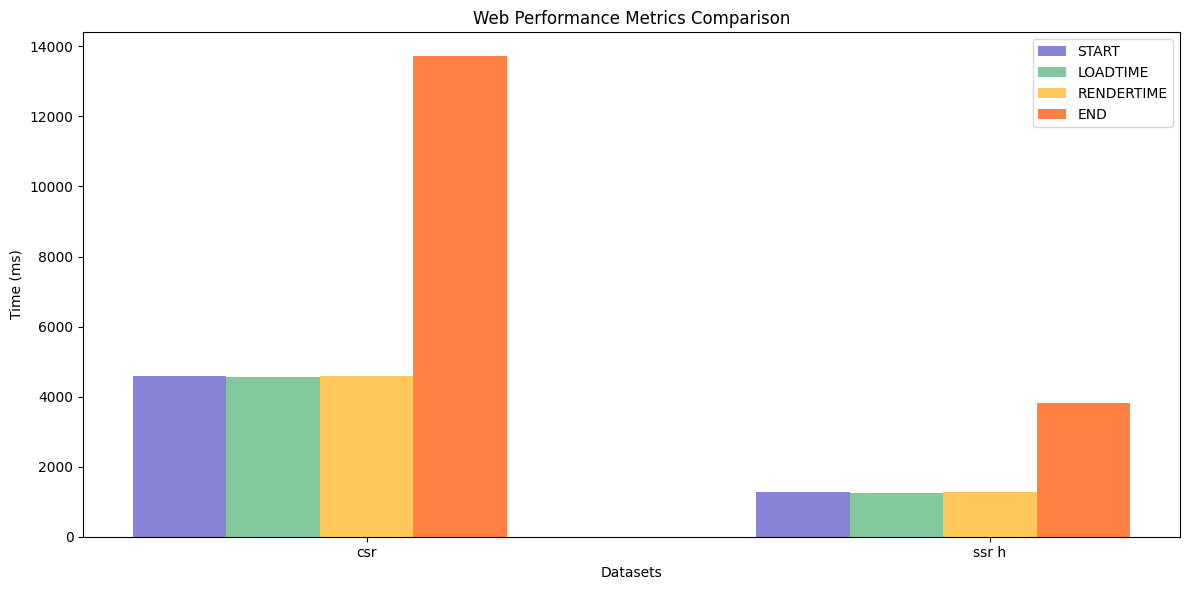

In [10]:
# Create a figure
metric_order = ['start','loadTime','renderTime','end'] 
plt.figure(figsize=(12, 6))

# Set width of bars and positions
x = np.arange(len(datasets))
bar_width = 0.15  # Smaller width since we have more bars per group
colors = ['#8884d8', '#82ca9d', '#ffc658', '#ff8042', '#a4de6c']

# Plot each metric as a set of bars
for i, metric in enumerate(metric_order):
    values = [dataset[metric].quantile(0.75) for name, dataset in cleaned_datasets.items()]
    position = x + (i - len(metrics)/2 + 0.5) * bar_width
    plt.bar(position, values, bar_width, label=metric.upper(), color=colors[i])

# Customize the plot
plt.xlabel('Datasets')
plt.ylabel('Time (ms)')
plt.title('Web Performance Metrics Comparison')
plt.xticks(x, datasets.keys())
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()